# <font color='blue'>Table of contents</font>

- [LeNet5 Architecture](#lenet)
- [Display the Network](#display)
- [Get the Fashion-MNIST Data](#get-data)
- [System Configuration](#sys-config)
- [Training Configuration](#train-config)
- [System Setup](#sys-setup)
- [Training](#training)
- [Validation](#validation)
- [Main function](#main)
- [Plot Loss](#plot-loss)
- [Miscellaneous](#misc)

# <font style="color:blue">Convolutional Neural Network Using Batch Normalization</font>

In this notebook, we  add batch norm layers to the LeNet network, and see how it affects network training and convergence.

Instead of the MNIST dataset, which overfits easily, we will use the Fashion MNIST dataset.

The figure below shows some samples from the Fashion MNIST dataset.

<img src="https://www.learnopencv.com/wp-content/uploads/2021/01/c3-w3-fashion-mnist-sprite.jpg" width="600">

There are 10 classes. Each training and testing example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |



We want to classify images in this dataset, using the LeNet network.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python

In [2]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

## <font style="color:green">1. LeNet Architecture with BatchNorm</font><a name="lenet"></a>

We have already explained the architecture for LeNet in the previous notebook.

Here, we create another model called LeNetBN, adding Batch Normalization layers to the 2 convolution blocks.

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer which is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

In [5]:
class LeNetBN(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weight in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

## <font style="color:green">2. Display the Network</font><a name="display"></a>

In [6]:
lenet_model = LeNet()
print(lenet_model)
lenetBN_model = LeNetBN()
print(lenetBN_model)

LeNet(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNetBN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Bat

## <font style="color:green">3. Get Fashion-MNIST Data</font><a name="get-data"></a>

In [7]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify for yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

## <font style="color:green">4. System Configuration</font><a name="sys-config"></a>

In [8]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

## <font style="color:green">5. Training Configuration</font><a name="train-config"></a>

In [9]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.
    


## <font style="color:green">6. System Setup</font><a name="sys-setup"></a>

In [10]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">7. Training</font><a name="training"></a>
We are familiar with the training pipeline used in PyTorch.

In [11]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

## <font style="color:green">8. Validation</font><a name="validation"></a>

After every few epochs **`validation`** is called, with the `trained model` and `test_loader` to get validation loss and accuracy.

**Note:** We use `model.eval()` to enable evaluation mode of the model. This will stop calculating the running estimate of mean and variance of data. Using instead just the mean and variance computed while training.

In [12]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            indx_target = target.clone()
            data = data.to(train_config.device)

            target = target.to(train_config.device)

            output = model(data)
            # add loss for each mini batch
            test_loss += F.cross_entropy(output, target).item()

            # get probability score using softmax
            prob = F.softmax(output, dim=1)

            # get the index of the max probability
            pred = prob.data.max(dim=1)[1] 

            # add correct prediction count
            count_corect_predictions += pred.cpu().eq(indx_target).sum()

        # average over number of mini-batches
        test_loss = test_loss / len(test_loader)  

        # average over number of dataset
        accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )
    return test_loss, accuracy/100.0

## <font style="color:green">9. Main</font><a name="main"></a>


Here, we use the configuration parameters defined above and start  training. 

1. Set up system parameters like CPU/GPU, number of threads etc.
1. Load the data using dataloaders.
1. Create an instance of the LeNet model.
1. Specify optimizer to use.
1. Set up variables to track loss and accuracy and start training.

In [13]:
def main(model, system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 10

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [14]:
model = LeNet()
modelBN = LeNetBN() 

model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main(model)

modelBN, epoch_train_loss_bn, epoch_train_acc_bn, epoch_test_loss_bn, epoch_test_acc_bn = main(modelBN)

0it [00:00, ?it/s]

26427392it [00:08, 3172115.21it/s]                              


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 43757.35it/s]                           
0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


4423680it [00:01, 2839659.97it/s]                             
0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


8192it [00:00, 26669.86it/s]            


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!
Train Epoch: 0 [3200/60000] Loss: 2.305011 Acc: 0.1250
Train Epoch: 0 [6400/60000] Loss: 2.261773 Acc: 0.2500
Train Epoch: 0 [9600/60000] Loss: 2.048268 Acc: 0.4062
Train Epoch: 0 [12800/60000] Loss: 1.379581 Acc: 0.3750
Train Epoch: 0 [16000/60000] Loss: 0.889184 Acc: 0.6562
Train Epoch: 0 [19200/60000] Loss: 0.932409 Acc: 0.6250
Train Epoch: 0 [22400/60000] Loss: 1.240133 Acc: 0.5312
Train Epoch: 0 [25600/60000] Loss: 0.985355 Acc: 0.7500
Train Epoch: 0 [28800/60000] Loss: 1.010952 Acc: 0.6875
Train Epoch: 0 [32000/60000] Loss: 1.049646 Acc: 0.5312
Train Epoch: 0 [35200/60000] Loss: 0.838904 Acc: 0.7188
Train Epoch: 0 [38400/60000] Loss: 0.890075 Acc: 0.6875
Train Epoch: 0 [41600/60000] Loss: 0.589139 Acc: 0.8438
Train Epoch: 0 [44800/60000] Loss: 0.887304 Acc: 0.6562
Train Epoch: 0 [48000/60000] Loss: 0.827041 Acc: 0.6875
Train Epoch: 0 [51200/60000] Loss: 0.683016 Acc: 0.7500
Tra

Train Epoch: 7 [19200/60000] Loss: 0.239725 Acc: 0.9062
Train Epoch: 7 [22400/60000] Loss: 0.315298 Acc: 0.9062
Train Epoch: 7 [25600/60000] Loss: 0.394747 Acc: 0.7812
Train Epoch: 7 [28800/60000] Loss: 0.182193 Acc: 0.9688
Train Epoch: 7 [32000/60000] Loss: 0.447015 Acc: 0.8125
Train Epoch: 7 [35200/60000] Loss: 0.354310 Acc: 0.8750
Train Epoch: 7 [38400/60000] Loss: 0.264993 Acc: 0.8750
Train Epoch: 7 [41600/60000] Loss: 0.363598 Acc: 0.8750
Train Epoch: 7 [44800/60000] Loss: 0.156804 Acc: 0.9375
Train Epoch: 7 [48000/60000] Loss: 0.387383 Acc: 0.8438
Train Epoch: 7 [51200/60000] Loss: 0.133595 Acc: 0.9375
Train Epoch: 7 [54400/60000] Loss: 0.280993 Acc: 0.9062
Train Epoch: 7 [57600/60000] Loss: 0.650849 Acc: 0.7500
Elapsed 48.63s, 6.08 s/epoch, 0.00 s/batch, ets 72.95s

Test set: Average loss: 0.3489, Accuracy: 8723/10000 (87%)

Train Epoch: 8 [3200/60000] Loss: 0.299913 Acc: 0.9062
Train Epoch: 8 [6400/60000] Loss: 0.171295 Acc: 0.9375
Train Epoch: 8 [9600/60000] Loss: 0.376844 Acc

Train Epoch: 14 [35200/60000] Loss: 0.242817 Acc: 0.9062
Train Epoch: 14 [38400/60000] Loss: 0.300826 Acc: 0.8438
Train Epoch: 14 [41600/60000] Loss: 0.155230 Acc: 0.9375
Train Epoch: 14 [44800/60000] Loss: 0.154523 Acc: 0.9375
Train Epoch: 14 [48000/60000] Loss: 0.119851 Acc: 0.9688
Train Epoch: 14 [51200/60000] Loss: 0.466593 Acc: 0.8438
Train Epoch: 14 [54400/60000] Loss: 0.208276 Acc: 0.9062
Train Epoch: 14 [57600/60000] Loss: 0.106473 Acc: 1.0000
Elapsed 92.12s, 6.14 s/epoch, 0.00 s/batch, ets 30.71s

Test set: Average loss: 0.3120, Accuracy: 8851/10000 (89%)

Train Epoch: 15 [3200/60000] Loss: 0.278953 Acc: 0.8750
Train Epoch: 15 [6400/60000] Loss: 0.156669 Acc: 0.9375
Train Epoch: 15 [9600/60000] Loss: 0.127001 Acc: 0.9375
Train Epoch: 15 [12800/60000] Loss: 0.136738 Acc: 1.0000
Train Epoch: 15 [16000/60000] Loss: 0.237523 Acc: 0.8750
Train Epoch: 15 [19200/60000] Loss: 0.271087 Acc: 0.8438
Train Epoch: 15 [22400/60000] Loss: 0.165440 Acc: 0.9062
Train Epoch: 15 [25600/60000] Lo

Train Epoch: 1 [48000/60000] Loss: 0.315432 Acc: 0.9062
Train Epoch: 1 [51200/60000] Loss: 0.236998 Acc: 0.8750
Train Epoch: 1 [54400/60000] Loss: 0.230768 Acc: 0.9062
Train Epoch: 1 [57600/60000] Loss: 0.290227 Acc: 0.8750
Elapsed 12.70s, 6.35 s/epoch, 0.00 s/batch, ets 114.29s

Test set: Average loss: 0.3979, Accuracy: 8558/10000 (86%)

Train Epoch: 2 [3200/60000] Loss: 0.436743 Acc: 0.7812
Train Epoch: 2 [6400/60000] Loss: 0.306836 Acc: 0.9062
Train Epoch: 2 [9600/60000] Loss: 0.265878 Acc: 0.8750
Train Epoch: 2 [12800/60000] Loss: 0.375737 Acc: 0.8438
Train Epoch: 2 [16000/60000] Loss: 0.562706 Acc: 0.7812
Train Epoch: 2 [19200/60000] Loss: 0.219371 Acc: 0.9375
Train Epoch: 2 [22400/60000] Loss: 0.332222 Acc: 0.9375
Train Epoch: 2 [25600/60000] Loss: 0.237044 Acc: 0.9062
Train Epoch: 2 [28800/60000] Loss: 0.389849 Acc: 0.8750
Train Epoch: 2 [32000/60000] Loss: 0.365898 Acc: 0.7812
Train Epoch: 2 [35200/60000] Loss: 0.212068 Acc: 0.9375
Train Epoch: 2 [38400/60000] Loss: 0.467402 Ac

Train Epoch: 9 [6400/60000] Loss: 0.425166 Acc: 0.8438
Train Epoch: 9 [9600/60000] Loss: 0.122013 Acc: 0.9688
Train Epoch: 9 [12800/60000] Loss: 0.418962 Acc: 0.9375
Train Epoch: 9 [16000/60000] Loss: 0.122426 Acc: 0.9375
Train Epoch: 9 [19200/60000] Loss: 0.151508 Acc: 0.9062
Train Epoch: 9 [22400/60000] Loss: 0.311149 Acc: 0.8438
Train Epoch: 9 [25600/60000] Loss: 0.170491 Acc: 0.9062
Train Epoch: 9 [28800/60000] Loss: 0.512506 Acc: 0.8125
Train Epoch: 9 [32000/60000] Loss: 0.182610 Acc: 0.9688
Train Epoch: 9 [35200/60000] Loss: 0.144600 Acc: 1.0000
Train Epoch: 9 [38400/60000] Loss: 0.105158 Acc: 1.0000
Train Epoch: 9 [41600/60000] Loss: 0.112190 Acc: 1.0000
Train Epoch: 9 [44800/60000] Loss: 0.143535 Acc: 0.9688
Train Epoch: 9 [48000/60000] Loss: 0.059460 Acc: 1.0000
Train Epoch: 9 [51200/60000] Loss: 0.376045 Acc: 0.8750
Train Epoch: 9 [54400/60000] Loss: 0.534732 Acc: 0.8125
Train Epoch: 9 [57600/60000] Loss: 0.239681 Acc: 0.9375
Elapsed 66.02s, 6.60 s/epoch, 0.00 s/batch, ets 66

Train Epoch: 16 [22400/60000] Loss: 0.347742 Acc: 0.8438
Train Epoch: 16 [25600/60000] Loss: 0.180350 Acc: 0.9375
Train Epoch: 16 [28800/60000] Loss: 0.058046 Acc: 1.0000
Train Epoch: 16 [32000/60000] Loss: 0.266591 Acc: 0.9375
Train Epoch: 16 [35200/60000] Loss: 0.218201 Acc: 0.8750
Train Epoch: 16 [38400/60000] Loss: 0.070371 Acc: 1.0000
Train Epoch: 16 [41600/60000] Loss: 0.115711 Acc: 0.9375
Train Epoch: 16 [44800/60000] Loss: 0.256617 Acc: 0.8750
Train Epoch: 16 [48000/60000] Loss: 0.150983 Acc: 0.9375
Train Epoch: 16 [51200/60000] Loss: 0.107541 Acc: 0.9375
Train Epoch: 16 [54400/60000] Loss: 0.057391 Acc: 0.9688
Train Epoch: 16 [57600/60000] Loss: 0.258996 Acc: 0.8750
Elapsed 113.72s, 6.69 s/epoch, 0.00 s/batch, ets 20.07s

Test set: Average loss: 0.2854, Accuracy: 8972/10000 (90%)

Train Epoch: 17 [3200/60000] Loss: 0.350819 Acc: 0.8750
Train Epoch: 17 [6400/60000] Loss: 0.221051 Acc: 0.9375
Train Epoch: 17 [9600/60000] Loss: 0.160791 Acc: 0.9688
Train Epoch: 17 [12800/60000] L

## <font style="color:green">10. Plot Loss</font> <a name="plot-loss"></a>


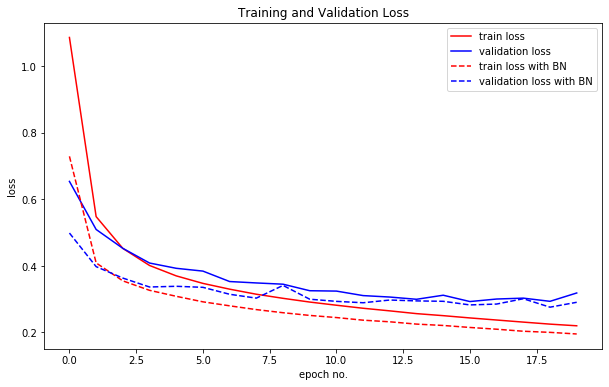

In [15]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, 'r', label="train loss")
plt.plot(x, epoch_test_loss, 'b', label="validation loss")

plt.plot(x, epoch_train_loss_bn, 'r--', label="train loss with BN")
plt.plot(x, epoch_test_loss_bn, 'b--',label="validation loss with BN")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The above curves show that when we use Batch Normalization, the training converges faster.

## <font style="color:blue">Miscellaneous: Calculate Mean and Standard Deviation of Fashion MNIST </font> <a name="misc"></a>

Ideally, we should not use the same mean and standard deviation for Fashion MNIST and MNIST. Refrain, even when you find many continuing to do this, simply because it does not have a profound effect on the results.

Let us find  the mean and standard deviation for Fashion MNIST and use it instead of MNIST.

We need to simply find the mean and standard deviation of the whole dataset. So, we load the dataset and then use the functions given below:

In [4]:
import torchvision
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transform)

print(train_set.data.float().mean()/255)
print(train_set.data.float().std()/255)

tensor(0.2860)
tensor(0.3530)
